In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


# Data loading

In [36]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

# Plotting

In [37]:
def set_axis(axis_data):
    """Helper function to set axis ticks"""
    n = len(axis_data)
    positions = np.linspace(0, n-1, min(10, n))
    labels = [axis_data[int(p)] for p in positions]
    return positions, labels

def plot_data(result, figsize=(12, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot DAS data as a heatmap (time vs distance).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plot
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    df = result['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Plot the data
    im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    
    plt.ylabel('time')
    plt.xlabel('space [m]')
    
    # Add colorbar with custom positioning
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    plt.show()
    
    return fig, ax

def plot_comparison(result1, result2, title1="Original", title2="Processed", 
                    figsize=(24, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot two DAS datasets side by side for comparison.
    
    Parameters:
    -----------
    result1, result2 : dict
        Dictionaries returned by get_range() or filter functions
    title1, title2 : str
        Titles for the left and right plots
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plots
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes objects
    """
    df1 = result1['df'].copy()
    df2 = result2['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df1 -= df1.mean()
        df1 = np.abs(df1)
        df2 -= df2.mean()
        df2 = np.abs(df2)
    
    # Normalize using percentiles
    low, high = np.percentile(df1, percentiles)
    low2, high2 = np.percentile(df2, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    norm2 = Normalize(vmin=low2, vmax=high2, clip=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot left (original)
    im1 = ax1.imshow(df1, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    ax1.set_ylabel('time')
    ax1.set_xlabel('space [m]')
    ax1.set_title(title1)
    
    x_positions1, x_labels1 = set_axis(df1.columns)
    ax1.set_xticks(x_positions1, np.round(x_labels1))
    y_positions1, y_labels1 = set_axis(df1.index.time)
    ax1.set_yticks(y_positions1, y_labels1)
    
    # Plot right (processed)
    im2 = ax2.imshow(df2, interpolation='none', aspect='auto', norm=norm2, cmap=cmap)
    ax2.set_ylabel('time')
    ax2.set_xlabel('space [m]')
    ax2.set_title(title2)
    
    x_positions2, x_labels2 = set_axis(df2.columns)
    ax2.set_xticks(x_positions2, np.round(x_labels2))
    y_positions2, y_labels2 = set_axis(df2.index.time)
    ax2.set_yticks(y_positions2, y_labels2)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Amplitude')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Preprocessing

In [58]:
def bandpass_filter(result, lowcut=5, highcut=50, order=4):
    """
    Apply bandpass filter to DAS data to isolate vehicle frequencies.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lowcut : float
        Low cutoff frequency in Hz (default: 5 Hz)
    highcut : float
        High cutoff frequency in Hz (default: 50 Hz)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    # Normalize cutoff frequencies
    nyquist = fs / 2.0
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to each spatial channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = filtfilt(b, a, data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def median_subtract_filter(result):
    """
    Subtract the median value from each channel to remove DC offset and baseline drift.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    
    Returns:
    --------
    dict : Same structure as input with median-subtracted data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Subtract median from each channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = data[:, i] - np.median(data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }
    
def zero_columns(data, col_start, col_end):
    # Zero out specified columns in the DAS data.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = array.copy()
    modified_array[:, col_start:col_end] = 0
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }

def power_data_to_x(data, power=2):
    # Raise the absolute value of the data to a specified power.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = np.abs(array) ** power
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }
    

# Other functions

In [122]:
def find_channel_frequencies(result, channel_index=24, threshold_percentile=85, 
                            merge_gap=50, min_sector_length=3):
    """
    Find frequencies of continuous high-amplitude sectors on a specific channel.
    
    This function identifies continuous segments (sectors) on a single channel that
    exceed a threshold, merges nearby sectors, then calculates their frequencies based on duration.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of frequencies [Hz] for each detected sector group
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    dt = result['dt']
    data = result['data']
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    # Where signal changes from 0 to 1 or 1 to 0
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                # Merge with previous sector
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                # Start new sector
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate properties for each merged sector
    sector_lengths = ends - starts  # Length in samples
    durations = sector_lengths * dt  # Duration in seconds
    
    # Calculate frequency for each sector: f = 1 / T
    frequencies = np.array([1.0 / duration if duration > 0 else 0 for duration in durations])
    
    print("="*70)
    print(f"CHANNEL {channel_index} FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Merged sectors detected: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED MERGED SECTORS:")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Merged':<8}")
        print(f"{'-'*70}")
        
        for i, (start, end, length, duration, freq, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, frequencies, num_merged)):
            if i < 20:  # Show first 20
                print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {n_merged:<8}")
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more sectors")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(frequencies)}")
        print(f"  Sector lengths: {np.min(sector_lengths)} to {np.max(sector_lengths)} samples")
        print(f"  Durations: {np.min(durations)*1000:.2f} to {np.max(durations)*1000:.2f} ms")
        print(f"  Frequencies: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):  # Highlight first 50 sectors
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Duration vs Frequency scatter
        ax = axes[1, 1]
        ax.scatter(durations * 1000, frequencies, alpha=0.5, s=20)
        ax.set_xlabel('Duration [ms]')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_title('Duration vs Frequency', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo sectors detected above threshold.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

def notch_filter_frequencies(result, frequencies_to_remove, bandwidth=2.0, order=2):
    """
    Apply notch filters to remove specific frequencies from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth of each notch filter in Hz (default: 2.0)
    order : int
        Filter order for each notch (default: 2)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.signal import iirnotch
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    print("="*70)
    print("NOTCH FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequencies:")
    
    # Apply notch filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        if freq <= 0 or freq >= fs / 2:
            print(f"  Skipping {freq:.2f} Hz (out of valid range)")
            continue
        
        # Design notch filter
        # Q factor determines bandwidth: BW = freq / Q
        Q = freq / bandwidth
        b, a = iirnotch(freq, Q, fs)
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {freq:.2f} Hz (Q={Q:.2f}, BW={bandwidth:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandstop_filter_frequencies(result, frequencies_to_remove, bandwidth=5.0, order=4):
    """
    Apply bandstop (band-reject) filters to remove specific frequency bands from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of center frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth around each center frequency to remove in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDSTOP FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequency bands:")
    
    # Apply bandstop filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandstop filter
        b, a = butter(order, [low, high], btype='bandstop')
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandpass_keep_frequencies(result, frequencies_to_keep, bandwidth=5.0, order=4):
    """
    Apply bandpass filters to KEEP ONLY specific frequencies from DAS data.
    All other frequencies will be removed.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_keep : array-like
        List or array of center frequencies [Hz] to KEEP in the signal
    bandwidth : float
        Bandwidth around each center frequency to keep in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDPASS KEEP ONLY SPECIFIC FREQUENCIES")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Keeping {len(frequencies_to_keep)} frequency bands:")
    
    # Start with zeros - we'll add each frequency band
    filtered_data = np.zeros_like(data)
    
    for freq in frequencies_to_keep:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandpass filter
        b, a = butter(order, [low, high], btype='bandpass')
        
        # Apply filter to each spatial channel and ADD to result
        for i in range(data.shape[1]):
            filtered_data[:, i] += filtfilt(b, a, data[:, i])
        
        print(f"  Kept {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


In [154]:
def find_channel_frequencies_fft(result, channel_index=24, threshold_percentile=85, 
                                merge_gap=50, min_sector_length=3, 
                                min_freq=5, max_freq=50, top_n_peaks=1):
    """
    Find dominant signal frequencies using FFT analysis of high-amplitude sectors.
    
    Instead of calculating f=1/duration, this function applies FFT to each detected
    sector to find the actual oscillation frequencies in the signal content.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    min_freq : float
        Minimum frequency to consider in FFT analysis [Hz] (default: 5)
    max_freq : float
        Maximum frequency to consider in FFT analysis [Hz] (default: 50)
    top_n_peaks : int
        Number of top frequency peaks to extract per sector (default: 1)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of dominant frequencies [Hz] found via FFT
        'peak_powers': array of FFT peak powers for each frequency
        'sector_frequencies': list of arrays, each containing top frequencies for one sector
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    from scipy.fft import rfft, rfftfreq
    
    dt = result['dt']
    data = result['data']
    fs = 1.0 / dt
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate basic properties
    sector_lengths = ends - starts
    durations = sector_lengths * dt
    
    # FFT analysis for each sector
    all_frequencies = []
    all_peak_powers = []
    sector_frequencies_list = []
    
    for start, end in zip(starts, ends):
        # Extract sector signal
        sector_signal = channel_data[start:end]
        sector_length = len(sector_signal)
        
        # Apply FFT
        fft_result = rfft(sector_signal)
        fft_freqs = rfftfreq(sector_length, dt)
        fft_power = np.abs(fft_result)
        
        # Filter to frequency range of interest
        freq_mask = (fft_freqs >= min_freq) & (fft_freqs <= max_freq)
        valid_freqs = fft_freqs[freq_mask]
        valid_power = fft_power[freq_mask]
        
        if len(valid_freqs) == 0:
            continue
        
        # Find top N peaks
        n_peaks = min(top_n_peaks, len(valid_power))
        top_indices = np.argpartition(valid_power, -n_peaks)[-n_peaks:]
        top_indices = top_indices[np.argsort(valid_power[top_indices])[::-1]]
        
        sector_freqs = valid_freqs[top_indices]
        sector_powers = valid_power[top_indices]
        
        # Store results
        sector_frequencies_list.append(sector_freqs)
        all_frequencies.extend(sector_freqs)
        all_peak_powers.extend(sector_powers)
    
    frequencies = np.array(all_frequencies)
    peak_powers = np.array(all_peak_powers)
    
    print("="*70)
    print(f"CHANNEL {channel_index} FFT FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Sampling frequency (fs): {fs:.2f} Hz")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Frequency range: {min_freq}-{max_freq} Hz")
    print(f"  Top peaks per sector: {top_n_peaks}")
    print(f"  Merged sectors detected: {len(starts)}")
    print(f"  Total frequencies extracted: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED FREQUENCIES (via FFT):")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Power':<12}")
        print(f"{'-'*70}")
        
        displayed = 0
        for i, (start, end, length, duration, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, num_merged)):
            if i < len(sector_frequencies_list):
                for freq, power in zip(sector_frequencies_list[i], 
                                      [peak_powers[j] for j in range(len(peak_powers)) 
                                       if j < len(sector_frequencies_list[i])]):
                    if displayed < 20:
                        print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {power:>10.2e}")
                        displayed += 1
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more frequencies")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(starts)}")
        print(f"  Total frequencies: {len(frequencies)}")
        print(f"  Frequency range: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('FFT Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Frequency vs Power scatter
        ax = axes[1, 1]
        ax.scatter(frequencies, peak_powers, alpha=0.5, s=20)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('FFT Power')
        ax.set_title('Frequency vs FFT Power', fontsize=14, fontweight='bold')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo frequencies detected in specified range.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'peak_powers': peak_powers,
        'sector_frequencies': sector_frequencies_list,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

In [191]:
def percentile_filter(result, lower_percentile=10, upper_percentile=90):
    """
    Filter data to keep only values between specified percentiles.
    Values outside the range are set to the corresponding percentile boundary.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lower_percentile : float
        Lower percentile threshold (0-100, default: 10)
    upper_percentile : float
        Upper percentile threshold (0-100, default: 90)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate percentile thresholds
    lower_threshold = np.percentile(data, lower_percentile)
    upper_threshold = np.percentile(data, upper_percentile)
    
    print("="*70)
    print("PERCENTILE FILTERING")
    print("="*70)
    print(f"Lower percentile ({lower_percentile}%): {lower_threshold:.6f}")
    print(f"Upper percentile ({upper_percentile}%): {upper_threshold:.6f}")
    
    # Clip values to percentile range
    filtered_data = np.clip(data, lower_threshold, upper_threshold)
    
    # Calculate statistics
    original_range = np.max(data) - np.min(data)
    filtered_range = upper_threshold - lower_threshold
    percent_reduced = (1 - filtered_range / original_range) * 100
    
    print(f"\nOriginal data range: {np.min(data):.6f} to {np.max(data):.6f}")
    print(f"Filtered data range: {lower_threshold:.6f} to {upper_threshold:.6f}")
    print(f"Range reduction: {percent_reduced:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [ ]:
def horizontal_closing_filter(result, kernel_size=5, threshold_percentile=50):
    """
    Apply morphological closing filter horizontally to fill gaps in high-intensity areas.
    This connects broken line segments along the time axis (horizontal direction).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    kernel_size : int
        Size of the horizontal structuring element (default: 5)
        Larger values close bigger gaps
    threshold_percentile : float
        Percentile threshold to binarize data before morphological operation (default: 50)
        Higher values = more selective (only strongest signals)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate threshold for binarization
    threshold = np.percentile(np.abs(data), threshold_percentile)
    
    print("="*70)
    print("HORIZONTAL CLOSING FILTER")
    print("="*70)
    print(f"Kernel size: {kernel_size} samples ({kernel_size * dt * 1000:.2f} ms)")
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Threshold value: {threshold:.6f}")
    
    # Create horizontal structuring element (1 x kernel_size)
    # This only operates along time axis (rows), not space axis (columns)
    structure = np.zeros((1, kernel_size))
    structure[0, :] = 1
    
    print(f"Structuring element shape: {structure.shape} (vertical x horizontal)")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        
        # Binarize: 1 where above threshold, 0 elsewhere
        binary_data = (np.abs(channel_data) > threshold).astype(int)
        
        # Apply morphological closing horizontally
        # This fills small gaps between high-intensity regions
        closed_binary = binary_closing(binary_data.reshape(-1, 1), structure=structure)
        
        # Apply binary mask to original data
        # Where closing filled gaps, interpolate values
        filled_mask = closed_binary.flatten()
        filtered_channel = channel_data.copy()
        
        # For newly filled regions, use interpolated values
        newly_filled = (filled_mask == 1) & (binary_data == 0)
        if np.any(newly_filled):
            # Simple interpolation: use mean of surrounding high values
            filtered_channel[newly_filled] = np.mean(channel_data[binary_data == 1]) if np.any(binary_data) else 0
        
        filtered_data[:, i] = filtered_channel
    
    # Calculate statistics
    original_high_intensity = np.sum(np.abs(data) > threshold)
    filtered_high_intensity = np.sum(np.abs(filtered_data) > threshold)
    added_samples = filtered_high_intensity - original_high_intensity
    
    print(f"\nOriginal high-intensity samples: {original_high_intensity}")
    print(f"After closing: {filtered_high_intensity}")
    print(f"Samples added (gaps filled): {added_samples}")
    print(f"Percentage increase: {(added_samples / original_high_intensity * 100):.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [384]:
def horizontal_sobel_filter(result, intensity=1.0, channel_independent=False):
    """
    Apply horizontal Sobel filter to detect edges along the time axis.
    This enhances horizontal features like vehicle signatures moving across channels.
    
    The Sobel operator calculates the gradient in the horizontal direction,
    highlighting transitions and edges in the time domain.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    intensity : float
        Edge intensity multiplier (default: 1.0)
        Values > 1.0 increase contrast and edge visibility
        Values < 1.0 reduce edge intensity
        Recommended range: 0.5 to 5.0
    channel_independent : bool
        If True, process each channel independently (no cross-channel influence)
        If False, use standard 2D Sobel filter (default: False)
    
    Returns:
    --------
    dict : Same structure as input with Sobel-filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import sobel
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL SOBEL FILTER")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Edge intensity multiplier: {intensity}")
    print(f"Channel independent: {channel_independent}")
    print(f"Applying horizontal gradient detection...")
    
    if channel_independent:
        # Process each channel independently using 1D gradient
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            # Use simple gradient along time axis for each channel
            channel_gradient = np.gradient(data[:, i])
            filtered_data[:, i] = channel_gradient
        print(f"  Mode: 1D gradient per channel (no cross-channel mixing)")
    else:
        # Apply standard 2D horizontal Sobel filter
        # axis=1 means horizontal direction (along time axis)
        filtered_data = sobel(data, axis=1)
        print(f"  Mode: 2D Sobel (includes cross-channel smoothing)")
    
    # Apply intensity multiplier
    filtered_data = filtered_data * intensity
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    filtered_mean = np.mean(np.abs(filtered_data))
    original_max = np.max(np.abs(data))
    filtered_max = np.max(np.abs(filtered_data))
    
    print(f"\nOriginal data:")
    print(f"  Mean absolute value: {original_mean:.6f}")
    print(f"  Max absolute value: {original_max:.6f}")
    print(f"\nFiltered data (horizontal edges):")
    print(f"  Mean absolute value: {filtered_mean:.6f}")
    print(f"  Max absolute value: {filtered_max:.6f}")
    print(f"  Amplitude ratio: {filtered_max / original_max:.2f}")
    print(f"  Edge enhancement: {intensity}x")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [308]:
def wavelet_denoise_filter(result, wavelet='db4', level=None, threshold_scale=1.0):
    """
    Apply wavelet denoising to remove noise while preserving edges and features.
    This uses discrete wavelet transform (DWT) with soft thresholding.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    wavelet : str
        Wavelet family to use (default: 'db4' - Daubechies 4)
        Options: 'db1'-'db20', 'sym2'-'sym20', 'coif1'-'coif5', 'haar'
    level : int or None
        Decomposition level (default: None = automatic based on signal length)
    threshold_scale : float
        Scale factor for threshold (default: 1.0)
        Higher values = more aggressive denoising, Lower values = preserve more detail
    
    Returns:
    --------
    dict : Same structure as input with denoised data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    import pywt
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("WAVELET DENOISING FILTER")
    print("="*70)
    print(f"Wavelet: {wavelet}")
    print(f"Threshold scale: {threshold_scale}")
    
    # Determine decomposition level if not specified
    if level is None:
        level = pywt.dwt_max_level(data.shape[0], wavelet)
        level = min(level, 6)  # Cap at reasonable level
    
    print(f"Decomposition level: {level}")
    print(f"Processing {data.shape[1]} channels...")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        
        # Perform multilevel wavelet decomposition
        coeffs = pywt.wavedec(channel_data, wavelet, level=level)
        
        # Calculate noise standard deviation (using MAD estimator on finest detail coefficients)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        
        # Calculate threshold using universal threshold
        threshold = sigma * np.sqrt(2 * np.log(len(channel_data))) * threshold_scale
        
        # Apply soft thresholding to detail coefficients (not approximation)
        coeffs_thresh = [coeffs[0]]  # Keep approximation coefficients
        for coeff in coeffs[1:]:
            coeffs_thresh.append(pywt.threshold(coeff, threshold, mode='soft'))
        
        # Reconstruct signal
        filtered_data[:, i] = pywt.waverec(coeffs_thresh, wavelet)[:len(channel_data)]
    
    # Calculate statistics
    noise_removed = data - filtered_data
    noise_power = np.mean(noise_removed**2)
    signal_power = np.mean(filtered_data**2)
    snr_improvement = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    
    print(f"\nDenoising statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Noise std: {np.std(noise_removed):.6f}")
    print(f"  SNR improvement: {snr_improvement:.2f} dB")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def gaussian_filter(result, sigma=2.0, truncate=4.0):
    """
    Apply Gaussian smoothing filter to reduce noise.
    This performs convolution with a Gaussian kernel.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    sigma : float
        Standard deviation of the Gaussian kernel (default: 2.0)
        Larger values = more smoothing
    truncate : float
        Truncate the filter at this many standard deviations (default: 4.0)
    
    Returns:
    --------
    dict : Same structure as input with smoothed data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import gaussian_filter1d
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("GAUSSIAN SMOOTHING FILTER")
    print("="*70)
    print(f"Sigma: {sigma} samples ({sigma * dt * 1000:.2f} ms)")
    print(f"Truncate: {truncate} sigma")
    print(f"Effective kernel size: {int(2 * truncate * sigma + 1)} samples")
    print(f"Processing {data.shape[1]} channels...")
    
    # Apply Gaussian filter along time axis (axis=0) for each channel
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        filtered_data[:, i] = gaussian_filter1d(data[:, i], sigma=sigma, 
                                                truncate=truncate, axis=0)
    
    # Calculate statistics
    original_variance = np.var(data)
    filtered_variance = np.var(filtered_data)
    variance_reduction = (1 - filtered_variance / original_variance) * 100
    
    print(f"\nSmoothing statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Variance reduction: {variance_reduction:.2f}%")
    print(f"  Peak amplitude ratio: {np.max(np.abs(filtered_data)) / np.max(np.abs(data)):.2f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bilateral_filter(result, sigma_spatial=5.0, sigma_intensity=None, window_size=None):
    """
    Apply bilateral filter for edge-preserving smoothing.
    This smooths noise while preserving sharp edges and features.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    sigma_spatial : float
        Spatial standard deviation (controls spatial extent of smoothing) (default: 5.0)
        Larger values = smoother over larger distances
    sigma_intensity : float or None
        Intensity/range standard deviation (controls edge preservation) (default: None = auto)
        Smaller values = preserve more edges, Larger values = more smoothing across edges
    window_size : int or None
        Size of the bilateral filter window (default: None = 2*sigma_spatial)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Auto-calculate sigma_intensity if not provided
    if sigma_intensity is None:
        sigma_intensity = np.std(data) * 0.5
    
    # Auto-calculate window size if not provided
    if window_size is None:
        window_size = int(2 * sigma_spatial) * 2 + 1
    
    print("="*70)
    print("BILATERAL FILTER (Edge-Preserving)")
    print("="*70)
    print(f"Sigma spatial: {sigma_spatial} samples ({sigma_spatial * dt * 1000:.2f} ms)")
    print(f"Sigma intensity: {sigma_intensity:.6f}")
    print(f"Window size: {window_size} samples")
    print(f"Processing {data.shape[1]} channels...")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        filtered_channel = np.zeros_like(channel_data)
        
        half_window = window_size // 2
        
        # Apply bilateral filter
        for t in range(len(channel_data)):
            # Define window boundaries
            t_min = max(0, t - half_window)
            t_max = min(len(channel_data), t + half_window + 1)
            
            # Extract neighborhood
            neighborhood = channel_data[t_min:t_max]
            center_value = channel_data[t]
            
            # Calculate spatial distances
            spatial_dists = np.arange(t_min - t, t_max - t)
            spatial_weights = np.exp(-spatial_dists**2 / (2 * sigma_spatial**2))
            
            # Calculate intensity differences
            intensity_diffs = neighborhood - center_value
            intensity_weights = np.exp(-intensity_diffs**2 / (2 * sigma_intensity**2))
            
            # Combine weights
            combined_weights = spatial_weights * intensity_weights
            
            # Normalize and apply
            if np.sum(combined_weights) > 0:
                filtered_channel[t] = np.sum(neighborhood * combined_weights) / np.sum(combined_weights)
            else:
                filtered_channel[t] = center_value
        
        filtered_data[:, i] = filtered_channel
    
    # Calculate statistics
    edge_preservation = np.corrcoef(np.gradient(data.flatten()), 
                                   np.gradient(filtered_data.flatten()))[0, 1]
    
    print(f"\nFiltering statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Noise reduction: {(1 - np.std(filtered_data) / np.std(data)) * 100:.2f}%")
    print(f"  Edge preservation correlation: {edge_preservation:.3f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [314]:
def downsample_filter(result, factor=4, method='decimate'):
    """
    Downsample DAS data to reduce sampling rate and data size.
    
    This reduces the temporal sampling rate by keeping every Nth sample or 
    using anti-aliased decimation to avoid aliasing artifacts.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    factor : int
        Downsampling factor (default: 4)
        New sampling rate will be fs/factor
    method : str
        Downsampling method (default: 'decimate')
        'simple': Keep every Nth sample (fast but may cause aliasing)
        'decimate': Anti-aliased decimation using low-pass filter (recommended)
    
    Returns:
    --------
    dict : Same structure as input with downsampled data
        {'data': downsampled_array, 'df': downsampled_dataframe, 'dt': new_dt, 'dx': dx}
    
    Notes:
    ------
    - Original sampling rate: 625 Hz (dt=0.0016s)
    - Factor 2: 312.5 Hz, Factor 4: 156.25 Hz, Factor 8: 78.125 Hz
    - Nyquist theorem: Can only preserve frequencies up to fs/(2*factor)
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    fs_original = 1.0 / dt
    fs_new = fs_original / factor
    dt_new = 1.0 / fs_new
    nyquist_new = fs_new / 2.0
    
    print("="*70)
    print("DOWNSAMPLING FILTER")
    print("="*70)
    print(f"Method: {method}")
    print(f"Downsampling factor: {factor}")
    print(f"Original sampling rate: {fs_original:.2f} Hz (dt={dt*1000:.2f} ms)")
    print(f"New sampling rate: {fs_new:.2f} Hz (dt={dt_new*1000:.2f} ms)")
    print(f"New Nyquist frequency: {nyquist_new:.2f} Hz")
    print(f"Original data size: {data.shape[0]} samples")
    
    if method == 'simple':
        # Simple downsampling: keep every Nth sample
        downsampled_data = data[::factor, :]
        print(f"Using simple downsampling (no anti-aliasing filter)")
        
    elif method == 'decimate':
        # Anti-aliased decimation using scipy.signal.decimate
        from scipy.signal import decimate
        
        print(f"Using decimation with anti-aliasing filter...")
        downsampled_data = np.zeros((data.shape[0] // factor, data.shape[1]))
        
        for i in range(data.shape[1]):
            downsampled_data[:, i] = decimate(data[:, i], factor, zero_phase=True)
        
    else:
        raise ValueError(f"Unknown method: {method}. Use 'simple' or 'decimate'.")
    
    print(f"Downsampled data size: {downsampled_data.shape[0]} samples")
    print(f"Data reduction: {(1 - downsampled_data.shape[0] / data.shape[0]) * 100:.2f}%")
    
    # Create new time index
    original_start = df.index[0]
    new_index = pd.date_range(start=original_start, periods=downsampled_data.shape[0], freq=f"{dt_new}s")
    
    # Create downsampled DataFrame
    downsampled_df = pd.DataFrame(
        data=downsampled_data,
        index=new_index,
        columns=df.columns
    )
    
    print(f"\nSpectral considerations:")
    print(f"  Frequencies above {nyquist_new:.2f} Hz will be aliased")
    print(f"  Recommended: Apply bandpass filter (0-{nyquist_new:.2f} Hz) before downsampling")
    print("="*70 + "\n")
    
    return {
        'data': downsampled_data,
        'df': downsampled_df,
        'dt': dt_new,
        'dx': dx
    }

In [396]:
def binary_threshold_filter(result, threshold_percentile=50, mode='absolute', keep_values=False):
    """
    Apply binary thresholding to DAS data to create a binary mask or zero out low-amplitude values.
    
    This creates a binary representation where values above threshold become 1 (or original value)
    and values below threshold become 0.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_percentile : float
        Percentile threshold for binarization (default: 50)
        Higher values = more selective (only strongest signals pass)
    mode : str
        Thresholding mode (default: 'absolute')
        'absolute': Threshold based on absolute values |data|
        'positive': Threshold only positive values
        'negative': Threshold only negative values
    keep_values : bool
        If True, keeps original values above threshold (default: False)
        If False, creates binary output (0 or 1)
    
    Returns:
    --------
    dict : Same structure as input with thresholded data
        {'data': thresholded_array, 'df': thresholded_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("BINARY THRESHOLD FILTER")
    print("="*70)
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Mode: {mode}")
    print(f"Keep original values: {keep_values}")
    
    # Calculate threshold based on mode
    if mode == 'absolute':
        threshold_value = np.percentile(np.abs(data), threshold_percentile)
        mask = np.abs(data) > threshold_value
        print(f"Threshold value (absolute): {threshold_value:.6f}")
        
    elif mode == 'positive':
        positive_data = data[data > 0]
        if len(positive_data) > 0:
            threshold_value = np.percentile(positive_data, threshold_percentile)
            mask = data > threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (positive): {threshold_value:.6f}")
        
    elif mode == 'negative':
        negative_data = data[data < 0]
        if len(negative_data) > 0:
            threshold_value = np.percentile(np.abs(negative_data), threshold_percentile)
            mask = data < -threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (negative): {threshold_value:.6f}")
        
    else:
        raise ValueError(f"Unknown mode: {mode}. Use 'absolute', 'positive', or 'negative'.")
    
    # Apply threshold
    if keep_values:
        # Keep original values where mask is True, zero elsewhere
        filtered_data = np.where(mask, data, 0)
        print(f"Output: Original values above threshold, zeros below")
    else:
        # Create binary mask (0 or 1)
        filtered_data = mask.astype(float)
        print(f"Output: Binary (0 or 1)")
    
    # Calculate statistics
    total_samples = data.size
    samples_above = np.sum(mask)
    samples_below = total_samples - samples_above
    percent_above = (samples_above / total_samples) * 100
    
    print(f"\nThresholding statistics:")
    print(f"  Total samples: {total_samples}")
    print(f"  Samples above threshold: {samples_above} ({percent_above:.2f}%)")
    print(f"  Samples below threshold: {samples_below} ({100 - percent_above:.2f}%)")
    
    if keep_values:
        print(f"  Mean of kept values: {np.mean(filtered_data[filtered_data != 0]):.6f}")
        print(f"  Max of kept values: {np.max(np.abs(filtered_data)):.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [366]:
def horizontal_mean_filter(result, window_size=5):
    """
    Apply horizontal mean filter along the time axis (rows).
    This smooths data by averaging values in a sliding window along each row.
    
    Unlike 2D filters, this only operates horizontally (along time), treating each
    spatial channel independently.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    window_size : int
        Number of consecutive samples to average along time axis (default: 5)
        Larger values = more smoothing
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import uniform_filter1d
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL MEAN FILTER")
    print("="*70)
    print(f"Window size: {window_size} samples ({window_size * dt * 1000:.2f} ms)")
    print(f"Processing {data.shape[1]} channels...")
    print(f"Filtering along time axis (rows) only")
    
    # Apply uniform (mean) filter along time axis (axis=0) for each channel
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        filtered_data[:, i] = uniform_filter1d(data[:, i], size=window_size, axis=0, mode='reflect')
    
    # Calculate statistics
    original_variance = np.var(data)
    filtered_variance = np.var(filtered_data)
    variance_reduction = (1 - filtered_variance / original_variance) * 100
    
    print(f"\nSmoothing statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Variance reduction: {variance_reduction:.2f}%")
    print(f"  Peak amplitude ratio: {np.max(np.abs(filtered_data)) / np.max(np.abs(data)):.2f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [412]:
def radon_transform_detection(result, theta_range=None, velocity_range=None, threshold_percentile=90):
    """
    Apply Radon transform to detect linear features (vehicle tracks) and estimate velocities.
    
    The Radon transform detects lines in the data by summing along different angles.
    For DAS data, diagonal lines represent vehicles moving at constant velocity.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    theta_range : tuple or None
        (min_angle, max_angle) in degrees (default: None = -45 to 45 degrees)
        Negative angles: moving forward (left to right)
        Positive angles: moving backward (right to left)
    velocity_range : tuple or None
        (min_velocity, max_velocity) in m/s for filtering angles (default: None)
        If provided, converts velocity to angle range based on dx and dt
    threshold_percentile : float
        Percentile threshold for peak detection in Radon space (default: 90)
    
    Returns:
    --------
    dict : Analysis results containing:
        'radon_image': Radon transform result (theta x projection)
        'theta': Array of angles used (degrees)
        'velocities': Estimated velocities for each angle (m/s)
        'detected_angles': Angles where peaks were detected (degrees)
        'detected_velocities': Velocities corresponding to detected angles (m/s)
        'peaks': Peak intensities at detected angles
        'original_result': Original input data
    """
    from skimage.transform import radon
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("RADON TRANSFORM DETECTION")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Spatial resolution (dx): {dx:.2f} m")
    print(f"Temporal resolution (dt): {dt*1000:.2f} ms")
    
    # Prepare data: use absolute values and normalize
    data_abs = np.abs(data)
    data_norm = (data_abs - np.min(data_abs)) / (np.max(data_abs) - np.min(data_abs) + 1e-10)
    
    # Determine angle range
    if velocity_range is not None:
        # Convert velocity range to angle range
        # velocity = dx/dt * tan(theta)
        # theta = atan(velocity * dt/dx)
        min_vel, max_vel = velocity_range
        min_angle = np.degrees(np.arctan(min_vel * dt / dx))
        max_angle = np.degrees(np.arctan(max_vel * dt / dx))
        theta = np.linspace(min_angle, max_angle, 180)
        print(f"Velocity range: {min_vel:.2f} to {max_vel:.2f} m/s")
        print(f"Angle range: {min_angle:.2f}° to {max_angle:.2f}°")
    elif theta_range is not None:
        min_angle, max_angle = theta_range
        theta = np.linspace(min_angle, max_angle, 180)
        print(f"Angle range: {min_angle:.2f}° to {max_angle:.2f}°")
    else:
        # Default: -45 to 45 degrees
        theta = np.linspace(-45, 45, 180)
        print(f"Angle range: -45° to 45° (default)")
    
    print(f"Number of angles: {len(theta)}")
    print(f"\nApplying Radon transform...")
    
    # Apply Radon transform
    radon_image = radon(data_norm, theta=theta, circle=False)
    
    print(f"Radon transform shape: {radon_image.shape} (projections x angles)")
    
    # Calculate velocities for each angle
    # velocity = dx/dt * tan(theta_radians)
    theta_rad = np.radians(theta)
    velocities = (dx / dt) * np.tan(theta_rad)
    
    # Find peaks in Radon space
    # Sum along projection axis to get intensity for each angle
    angle_intensity = np.sum(radon_image, axis=0)
    
    # Detect peaks above threshold
    threshold = np.percentile(angle_intensity, threshold_percentile)
    peak_mask = angle_intensity > threshold
    
    detected_angles = theta[peak_mask]
    detected_velocities = velocities[peak_mask]
    peak_intensities = angle_intensity[peak_mask]
    
    # Sort by intensity
    sort_idx = np.argsort(peak_intensities)[::-1]
    detected_angles = detected_angles[sort_idx]
    detected_velocities = detected_velocities[sort_idx]
    peak_intensities = peak_intensities[sort_idx]
    
    print(f"\n{'='*70}")
    print(f"DETECTED OBJECTS:")
    print(f"{'='*70}")
    print(f"Threshold (percentile {threshold_percentile}): {threshold:.2f}")
    print(f"Peaks detected: {len(detected_angles)}")
    
    if len(detected_angles) > 0:
        print(f"\nTop detections (sorted by intensity):")
        print(f"{'#':<4} {'Angle':<12} {'Velocity':<15} {'Intensity':<12}")
        print(f"{'-'*50}")
        for i, (angle, vel, intensity) in enumerate(zip(detected_angles[:10], detected_velocities[:10], peak_intensities[:10])):
            print(f"{i+1:<4} {angle:>8.2f}°   {vel:>10.2f} m/s   {intensity:>10.2f}")
        
        if len(detected_angles) > 10:
            print(f"... and {len(detected_angles) - 10} more detections")
        
        print(f"\n{'='*70}")
        print(f"VELOCITY STATISTICS:")
        print(f"  Mean velocity: {np.mean(detected_velocities):.2f} m/s")
        print(f"  Median velocity: {np.median(detected_velocities):.2f} m/s")
        print(f"  Velocity range: {np.min(detected_velocities):.2f} to {np.max(detected_velocities):.2f} m/s")
    else:
        print(f"\nNo peaks detected above threshold.")
    
    print(f"{'='*70}\n")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Original data
    ax = axes[0, 0]
    im1 = ax.imshow(np.abs(data), aspect='auto', cmap='viridis', interpolation='none')
    ax.set_xlabel('Space (channels)')
    ax.set_ylabel('Time (samples)')
    ax.set_title('Original DAS Data', fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Amplitude')
    
    # Plot 2: Radon transform
    ax = axes[0, 1]
    im2 = ax.imshow(radon_image, aspect='auto', cmap='hot', 
                    extent=[theta[0], theta[-1], 0, radon_image.shape[0]], origin='lower')
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Projection')
    ax.set_title('Radon Transform', fontsize=14, fontweight='bold')
    
    # Mark detected angles
    if len(detected_angles) > 0:
        for angle in detected_angles[:5]:  # Mark top 5
            ax.axvline(angle, color='cyan', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.colorbar(im2, ax=ax, label='Intensity')
    
    # Plot 3: Angle intensity profile
    ax = axes[1, 0]
    ax.plot(theta, angle_intensity, 'b-', linewidth=2, label='Intensity')
    ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
    
    # Mark detected peaks
    if len(detected_angles) > 0:
        ax.plot(detected_angles, peak_intensities, 'go', markersize=10, label='Detected peaks')
    
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Integrated Intensity')
    ax.set_title('Angle Intensity Profile', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Velocity distribution
    ax = axes[1, 1]
    ax.plot(theta, velocities, 'b-', linewidth=2, label='Velocity curve')
    
    # Mark detected velocities
    if len(detected_velocities) > 0:
        ax.plot(detected_angles, detected_velocities, 'ro', markersize=10, label='Detected velocities')
        
        # Add velocity range annotation
        ax.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        ax.fill_between(theta, velocities, 0, alpha=0.2)
    
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Velocity (m/s)')
    ax.set_title('Angle to Velocity Mapping', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'radon_image': radon_image,
        'theta': theta,
        'velocities': velocities,
        'detected_angles': detected_angles,
        'detected_velocities': detected_velocities,
        'peaks': peak_intensities,
        'angle_intensity': angle_intensity,
        'original_result': result
    }

In [336]:
def aspect_ratio_correction(result, scale_time=1.0/23.0, scale_space=5.0):
    """
    Correct aspect ratio of DAS data by rescaling time and space dimensions.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    scale_time : float
        Scale factor for time axis (default: 1/23 to downsample ~75000 -> ~3250)
    scale_space : float
        Scale factor for space axis (default: 5 to upsample ~52 -> ~260)
    
    Returns:
    --------
    dict : Same structure as input with rescaled data
        {'data': rescaled_array, 'df': rescaled_dataframe, 'dt': dt, 'dx': dx}
    """
    from skimage.transform import rescale
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("ASPECT RATIO CORRECTION")
    print("="*70)
    print(f"Original shape: {data.shape} (time x space)")
    print(f"Scale time by: {scale_time:.4f}")
    print(f"Scale space by: {scale_space:.1f}")
    print(f"Target shape: ~({int(data.shape[0]*scale_time)} x {int(data.shape[1]*scale_space)})")
    
    # Rescale data - FAST, no anti-aliasing
    rescaled_data = rescale(data, (scale_time, scale_space), 
                           order=1,  # Linear interpolation (faster)
                           mode='edge', 
                           anti_aliasing=False,  # Skip anti-aliasing (much faster)
                           preserve_range=True)
    
    print(f"Actual rescaled shape: {rescaled_data.shape}")
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    rescaled_mean = np.mean(np.abs(rescaled_data))
    original_max = np.max(np.abs(data))
    rescaled_max = np.max(np.abs(rescaled_data))
    
    print(f"\nOriginal data:")
    print(f"  Mean: {original_mean:.6e}")
    print(f"  Max: {original_max:.6e}")
    print(f"\nRescaled data:")
    print(f"  Mean: {rescaled_mean:.6e}")
    print(f"  Max: {rescaled_max:.6e}")
    print("="*70 + "\n")
    
    # Create rescaled DataFrame with proper datetime index
    # Generate new index based on rescaled time dimension
    start_time = df.index[0] if hasattr(df.index, '_getitem_') else pd.Timestamp('2024-05-07 00:00:00')
    new_index = pd.date_range(start=start_time, periods=rescaled_data.shape[0], freq=f"{dt/scale_time}s")
    
    rescaled_df = pd.DataFrame(
        data=rescaled_data,
        index=new_index,
        columns=np.arange(rescaled_data.shape[1]) * dx
    )
    
    return {
        'data': rescaled_data,
        'df': rescaled_df,
        'dt': dt,
        'dx': dx,
        'scale_time': scale_time,
        'scale_space': scale_space
    }

In [357]:
def noise_removal_only(result, threshold_strong_percentile=99, threshold_weak_percentile=99, median_size=15):
    """
    Remove noise from data - fragment z smart_preprocessing który usuwa szum.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_strong_percentile : float
        Percentile for strong signals to keep unchanged (default: 99)
    threshold_weak_percentile : float
        Percentile for weak signals to remove (default: 99)
    median_size : int
        Size of median filter for medium-strength signals (default: 15)
    
    Returns:
    --------
    dict : Same structure as input with noise-removed data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import median_filter
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    n_time, n_space = data.shape
    
    print("="*70)
    print("NOISE REMOVAL")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Strong signal threshold: {threshold_strong_percentile}th percentile")
    print(f"Weak signal threshold: {threshold_weak_percentile}th percentile")
    print(f"Median filter size: {median_size}")
    
    # Process all columns
    data_filtered = data.copy()
    
    for ch in range(n_space):
        channel = data[:, ch]
        abs_channel = np.abs(channel)
        
        # Thresholds: STRONG (keep) and WEAK (remove)
        threshold_strong = np.percentile(abs_channel, threshold_strong_percentile)
        threshold_weak = np.percentile(abs_channel, threshold_weak_percentile)
        
        # Masks
        strong_mask = abs_channel > threshold_strong  # Very strong - KEEP
        weak_mask = abs_channel < threshold_weak      # Weak - REMOVE
        
        # Remove weak points
        result_channel = channel.copy()
        result_channel[weak_mask] = 0  # Remove weak points completely
        
        # For medium signals (between weak and strong) - median filter
        medium_mask = ~strong_mask & ~weak_mask
        if np.any(medium_mask):
            filtered = median_filter(channel, size=median_size)
            result_channel[medium_mask] = filtered[medium_mask]
        
        data_filtered[:, ch] = result_channel
    
    # Statistics
    original_nonzero = np.count_nonzero(data)
    filtered_nonzero = np.count_nonzero(data_filtered)
    removed_percent = (1 - filtered_nonzero / original_nonzero) * 100
    
    print(f"\nProcessed {n_space} columns")
    print(f"Original non-zero samples: {original_nonzero}")
    print(f"Filtered non-zero samples: {filtered_nonzero}")
    print(f"Removed: {removed_percent:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=data_filtered,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': data_filtered,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

# Execuction

Initial sectors detected: 437
CHANNEL 20 FFT FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Sampling frequency (fs): 625.00 Hz
  Channel index: 20
  Threshold (percentile 95): 0.000001
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Frequency range: 5-50 Hz
  Top peaks per sector: 3
  Merged sectors detected: 5
  Total frequencies extracted: 15

DETECTED FREQUENCIES (via FFT):
#      Start      End        Length       Duration        Frequency    Power       
----------------------------------------------------------------------
1      35275      39530      4255            6808.00 ms        32.31 Hz     3.54e-04
1      35275      39530      4255            6808.00 ms        24.24 Hz     3.08e-04
1      35275      39530      4255            6808.00 ms        31.29 Hz     2.91e-04
2      45029      46425      1396            2233.60 ms        12.09 Hz     3.54e-04
2      45029      46425      1396            2233.60 ms        11

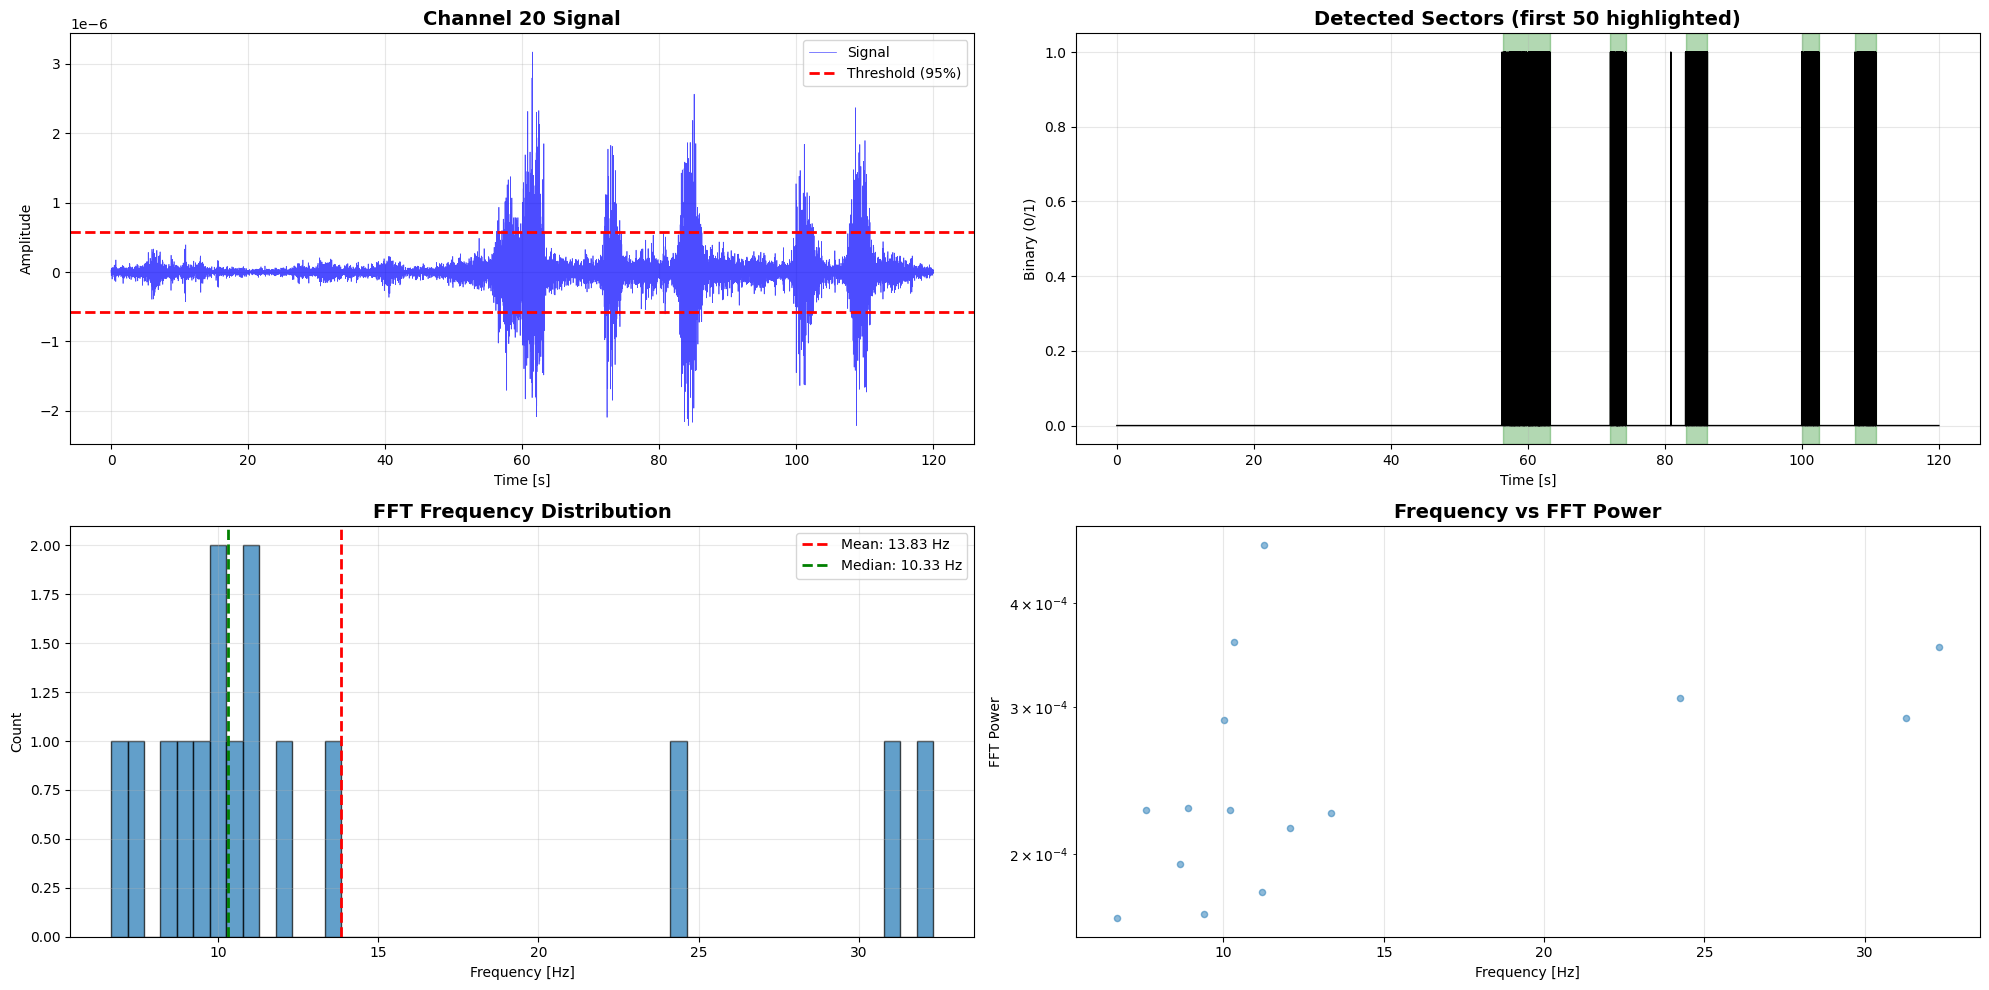



Detected frequencies (FFT): [32.31492362 24.23619271 31.2867215  12.08810888 11.19269341  9.40186246
 11.26690035 10.32799199 10.01502253 13.34798995  8.63693467  6.67399497
  8.88625592 10.20273828  7.56977357]
NOTCH FILTERING
Sampling frequency: 625.00 Hz
Removing 15 frequencies:
  Removed 32.31 Hz (Q=6.46, BW=5.00 Hz)
  Removed 24.24 Hz (Q=4.85, BW=5.00 Hz)
  Removed 31.29 Hz (Q=6.26, BW=5.00 Hz)
  Removed 24.24 Hz (Q=4.85, BW=5.00 Hz)
  Removed 31.29 Hz (Q=6.26, BW=5.00 Hz)
  Removed 12.09 Hz (Q=2.42, BW=5.00 Hz)
  Removed 11.19 Hz (Q=2.24, BW=5.00 Hz)
  Removed 12.09 Hz (Q=2.42, BW=5.00 Hz)
  Removed 11.19 Hz (Q=2.24, BW=5.00 Hz)
  Removed 9.40 Hz (Q=1.88, BW=5.00 Hz)
  Removed 11.27 Hz (Q=2.25, BW=5.00 Hz)
  Removed 9.40 Hz (Q=1.88, BW=5.00 Hz)
  Removed 11.27 Hz (Q=2.25, BW=5.00 Hz)
  Removed 10.33 Hz (Q=2.07, BW=5.00 Hz)
  Removed 10.02 Hz (Q=2.00, BW=5.00 Hz)
  Removed 13.35 Hz (Q=2.67, BW=5.00 Hz)
  Removed 10.33 Hz (Q=2.07, BW=5.00 Hz)
  Removed 10.02 Hz (Q=2.00, BW=5.00 H

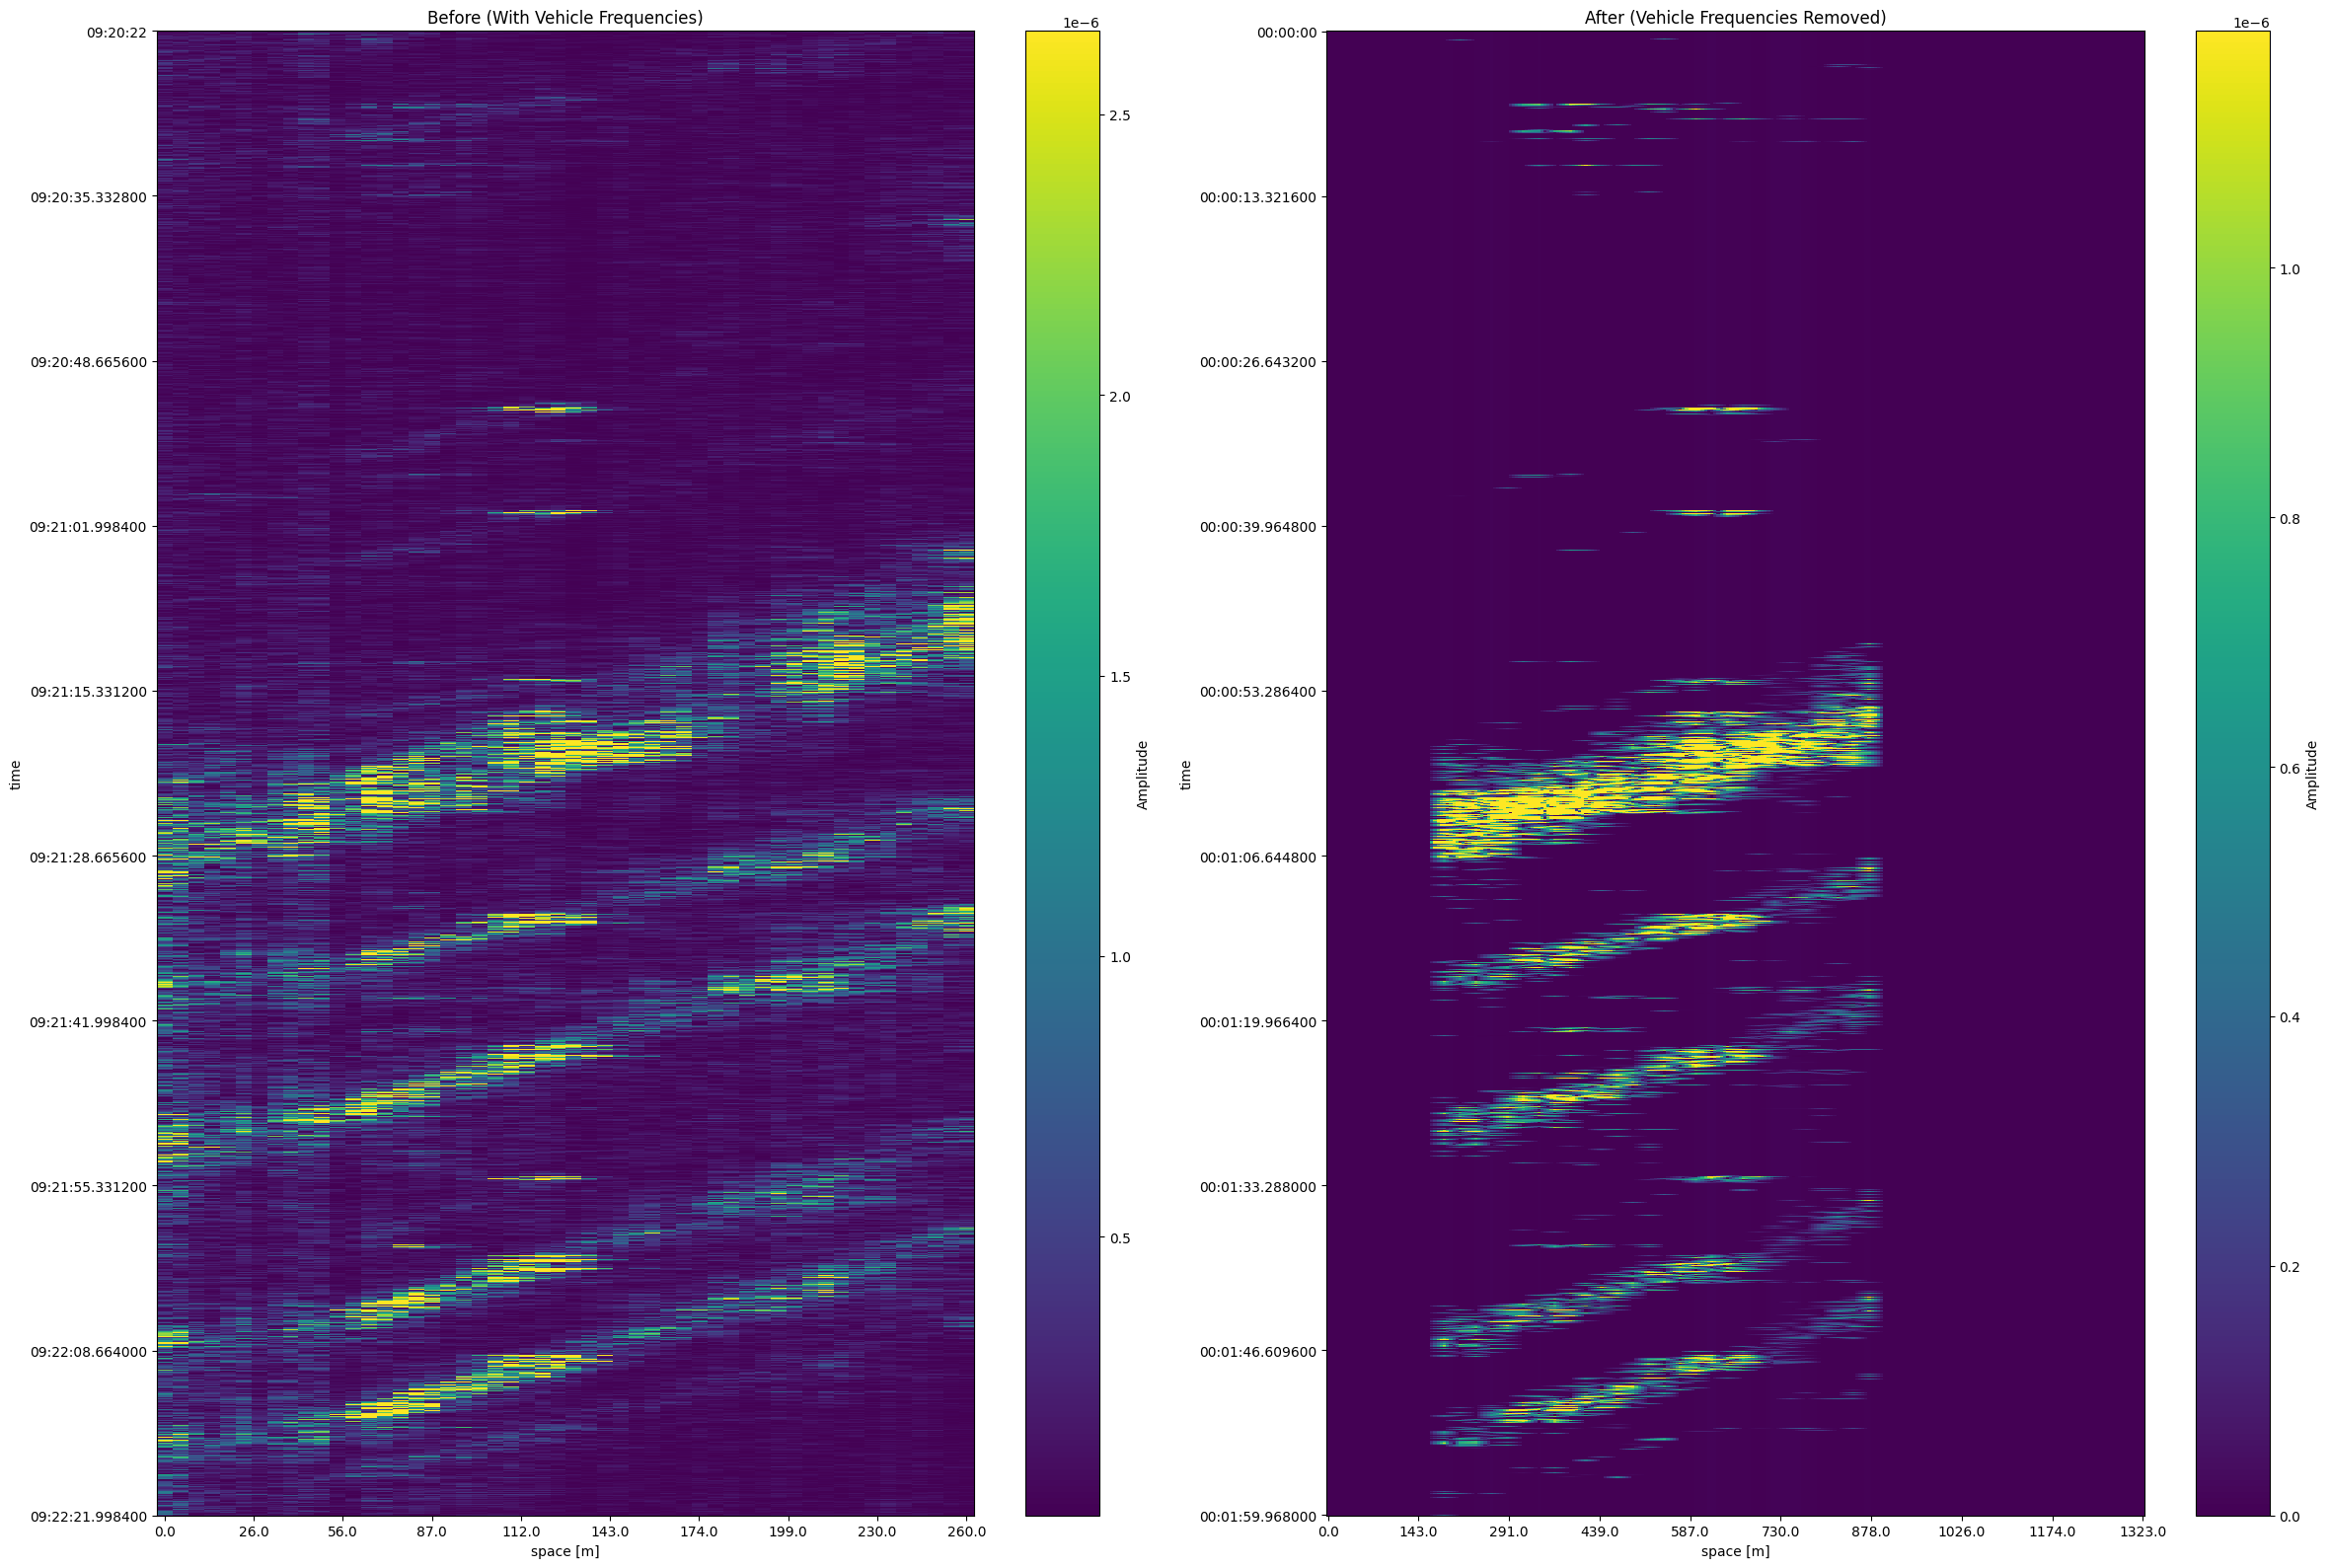

(<Figure size 2400x1600 with 4 Axes>,
 (<Axes: title={'center': 'Before (With Vehicle Frequencies)'}, xlabel='space [m]', ylabel='time'>,
  <Axes: title={'center': 'After (Vehicle Frequencies Removed)'}, xlabel='space [m]', ylabel='time'>))

In [ ]:
# Test notch filter with FFT-detected frequencies
raw_data = get_range(*range1)
data = zero_columns(raw_data, 0, 0)
bandpass_data = bandpass_filter(data, lowcut=5, highcut=50, order=4)

# Find frequencies using FFT analysis
result_fft = find_channel_frequencies_fft(bandpass_data, 
                                          channel_index=20, 
                                          threshold_percentile=95, 
                                          merge_gap=450,
                                          min_freq=5,
                                          max_freq=50,
                                          top_n_peaks=3)
print("\nDetected frequencies (FFT):", result_fft['frequencies'])

# REMOVE detected frequencies using notch filter
filtered_data = notch_filter_frequencies(bandpass_data, 
                                        result_fft['frequencies'], 
                                        bandwidth=5.0)

sobel_data = horizontal_sobel_filter(filtered_data)
noise_removed = noise_removal_only(sobel_data, threshold_strong_percentile=85, threshold_weak_percentile=85)
filtered_data = aspect_ratio_correction(noise_removed)

# Compare before and after
plot_comparison(raw_data, filtered_data, 
                title1="Before (With Vehicle Frequencies)", 
                title2="After (Vehicle Frequencies Removed)")

In [416]:
result = radon_transform_detection(filtered_data, threshold_percentile=90)
print("Detected velocities:", result['detected_velocities'])
print("Detected angles:", result['detected_angles'])

RADON TRANSFORM DETECTION
Data shape: (3261, 260) (time x space)
Spatial resolution (dx): 5.11 m
Temporal resolution (dt): 1.60 ms
Angle range: -45° to 45° (default)
Number of angles: 180

Applying Radon transform...


KeyboardInterrupt: 